In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("../code/modules")
import pickle
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.decomposition import PCA
import torch
from dynamical_models   import *
from generate_data      import *
from NbedDyn            import *
from stat_functions     import *
from DA import ENKF

from pdb import set_trace as bp
%matplotlib inline



In [2]:
class GD:
    model = 'Lorenz_63'
    class parameters:
        sigma = 10.0
        rho = 28.0
        beta = 8.0/3
    dt_integration = 0.01 # integration time
    dt_states = 1 # number of integeration times between consecutive states (for xt and catalog)
    dt_obs = 8# number of integration times between consecutive observations (for yo)
    var_obs = np.array([0,1]) # indices of the observed variables
    nb_loop_train = 110.01 # size of the catalog
    nb_loop_test = 100 # size of the true state and noisy observations
    sigma2_catalog = 0.0 # variance of the model error to generate the catalog
    sigma2_obs = 0.0 # variance of the observation error to generate observation

# run the data generation
X_train_chaos = Attractor_Lorenz = np.load('../data/X_train_L63_CHAOS.npy')
X_test  = np.load('../data/X_test_CHAOS.npy')

In [3]:
X_train    = X_train_chaos[:,:1]#[:-1,:1]
Grad_t     = np.gradient(X_train[:,0]).reshape(X_train.shape[0],1)/GD.dt_integration
Batch_size = X_train.shape[0]
nb_batch   = int(X_train.shape[0]/Batch_size)
X_train    = X_train.reshape(nb_batch,Batch_size,1)
Grad_t     = Grad_t.reshape(nb_batch,Batch_size,1)

In [4]:
initial_cond_idx = 400
length_prior = 100 # length of the initial condition


In [5]:
init_dict_opt = {} # collection of initial conditions to compare
init_dict_da = {}
plot_dict = {}

In [6]:
N_lat = 2
params = {}
params['seed']               = 0
params['transition_layers']  = 1
params['bi_linear_layers']   = N_lat+1
params['dim_hidden_linear']  = N_lat+1
params['dim_input']          = 1
params['dim_latent']         = N_lat
params['dim_observations']   = 1
params['dim_Embedding']      = N_lat+1
params['ntrain']             = [30000,1000]
params['dt_integration']     = 0.01
params['pretrained']         = False
params['nb_batch']           = nb_batch
params['Batch_size']         = Batch_size
params['get_latent_train']   = False
params['path']               = ''
params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])

In [7]:
for N_lat in range(2,3):
    for seed in range(0,1):
        params = {}
        params['seed']               = seed
        params['transition_layers']  = 1
        params['bi_linear_layers']   = N_lat+1
        params['dim_hidden_linear']  = N_lat+1
        params['dim_input']          = 1
        params['dim_latent']         = N_lat
        params['dim_observations']   = 1
        params['dim_Embedding']      = N_lat+1
        params['ntrain']             = [3000,100] # NOTE I MADE THIS SHORTER for ease
        params['dt_integration']     = 0.01
        params['pretrained']         = False
        params['nb_batch']           = nb_batch
        params['Batch_size']         = Batch_size
        params['get_latent_train']   = False
        params['path']               = ''
        params['file_name']          = 'NbedDyn_L63_dim_'+str(params['dim_Embedding'])+'_seed_'+str(params['seed'])
        model, modelRINN = get_NbedDyn_model(params)
        model, modelRINN, aug_inp_data = train_NbedDyn_model_L63(params,model,modelRINN,X_train,Grad_t)
        pred = [torch.cat((torch.from_numpy(X_train).float()[-1,-1:,:], modelRINN.Dyn_net.y_aug[-1,-1:,:]), dim=1)]

        for i in range(10000):
            pred.append(modelRINN(pred[-1],params['dt_integration'])[0])

        forecasting_err=np.zeros(1000)
        for i in range(1,100):
            forecasting_err[i-1]=RMSE(X_test[i-1,0],torch.stack(pred).data.numpy()[i,0,0])

        print('prediction error at t0 + dt : '  ,forecasting_err[0])
        print('prediction error at t0 + 4dt : ' ,forecasting_err[3])

        # SKIPPING LYAPUNOV STUFF BECAUSE IT IS SLOW AND NOT RELEVANT TO INITIALIZATION
#         l_exp, l_dim = Compute_Lyapunov_spectrum(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0), 10000, 0.1, 0.01, True)
#         lyap_series =  compute_largest_Lyapunov(modelRINN, np.concatenate((X_train[-1,-1,:], modelRINN.Dyn_net.y_aug.detach().numpy()[-1,-1,:]), axis=0),0.01,0.1,10000, True)[0]

#         print(l_exp)
#         print(lyap_series[-1])
#         print(l_dim)

        output_results = {}
        output_results['description']    = 'nbedDyn_model_output_dim'+str(params['dim_observations'])+'_seed_'+str(seed)
        output_results['pred']           = torch.stack(pred).data.numpy()
#         output_results['lyap_spect']     = l_exp
#         output_results['lyap_dim']       = l_dim
#         output_results['largest_lyap']   = lyap_series
        output_results['forecast_error'] = forecasting_err
        # write python dict to a file
        output = open(params['path']+params['file_name']+'.pkl', 'wb')
        pickle.dump(output_results, output)
        output.close()

0.001
Training L63 NbedDyn model 0 tensor(1519.1263, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 1000 tensor(0.0945, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 2000 tensor(0.0010, grad_fn=<AddBackward0>)
Training L63 NbedDyn model 0 tensor(0.0084, grad_fn=<AddBackward0>)
prediction error at t0 + dt :  1.7944542822334597e-05
prediction error at t0 + 4dt :  0.0004438094237393386


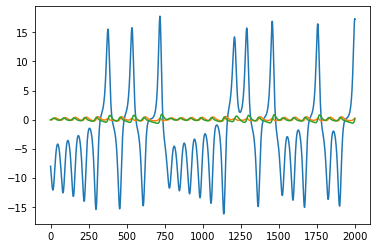

In [8]:
# plot dynamics of learned model---assess the variance of each state for good EnKF initialization
pred_vec = np.squeeze(torch.stack(pred).data.numpy())
plt.plot(pred_vec[:2000,:])

model_cov = np.diag(np.var(pred_vec,axis=0))

# Simple method : find analogs for the latent states in the training set:

In [20]:
def get_init(test_vars,length_prior,dt,dim_aug):
    x = torch.from_numpy(X_train).float()
    aug_inp = torch.cat((x[0,:,:], modelRINN.Dyn_net.y_aug[0,:,:]), dim=1)
    pred, grad, inp, aug_inp = modelRINN(aug_inp,dt)
    pred, aug = model_Multi_RINN_simple(aug_inp, 0.0, length_prior, dt)
    loss_init=[]
    for i in range(aug_inp.shape[0]):
        loss_init.append(((pred[1:,i,:1][torch.where(~torch.isnan(test_vars))]-test_vars[torch.where(~torch.isnan(test_vars))])**2).mean())
    min_idx = np.where(torch.stack(loss_init).data.numpy()==torch.stack(loss_init).data.numpy().min())
    inp_init = aug_inp.detach().data.numpy()[min_idx[0][0]].reshape(1,dim_aug)
    inp_init = (torch.from_numpy(inp_init).float())
    return inp_init
class Multi_INT_net(torch.nn.Module):
        def __init__(self, params):
            super(Multi_INT_net, self).__init__()
#            self.add_module('Dyn_net',FC_net(params))
            self.Int_net = modelRINN
        def forward(self, inp, t0, nb, dt):
            """
            In the forward function we accept a Tensor of input data and we must return
            a Tensor of output data. We can use Modules defined in the constructor as
            well as arbitrary operators on Tensors.
            """
#            dt = Variable(torch.from_numpy(np.reshape(dt,(1,1))).float())
#            x = Variable(3*torch.ones(1, 1), requires_grad=True)

            #grad, aug_inp = self.Dyn_net(inp,dt)
            #pred = aug_inp +dt*grad
            pred = [inp]
            aug  = []
            for i in range(nb):
                predic, k1, inp, aug_inp = self.Int_net(pred[-1], dt)
                pred.append(predic)
                aug.append(aug_inp)
            return torch.stack(pred), torch.stack(aug)
model_Multi_RINN_simple = Multi_INT_net(params)
criterion = torch.nn.MSELoss()

In [21]:
test_vars = (torch.from_numpy(np.reshape(X_test[initial_cond_idx:initial_cond_idx+length_prior,0],(length_prior,1))).float())
inp_init_knn = get_init(test_vars,length_prior,0.01,params['dim_Embedding'])
init_dict_opt['knn'] = inp_init_knn

y_pred2=np.zeros((2000+length_prior+1,params['dim_Embedding']))
tmp = inp_init_knn
y_pred2[0,:] = tmp.cpu().data.numpy()
for k in range(1,2000+length_prior+1):
    y_pred2[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
    tmp = (torch.from_numpy(np.reshape(y_pred2[k,:],(1,params['dim_Embedding']))).float())


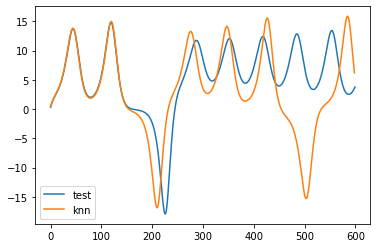

In [22]:
plt.plot(X_test[initial_cond_idx:,0], label='test')
plt.plot(y_pred2[1:(X_test.shape[0]-initial_cond_idx),0], label='knn')
plt.legend()
# plt.plot(y_pred2[1:600+1,0])

In [23]:
# Define noisy data
obs_noise_sd_true = 0.5
obs = np.copy(X_test[initial_cond_idx:initial_cond_idx+length_prior,0])
obs += obs_noise_sd_true*np.random.normal(0,1,obs.shape[0])
obs = obs[:,None]

In [24]:
# define DA scheme for identifying inits from noisy data
def get_initial_condition_DA(model, time_series, dt, obs_noise_sd_true, train_init=None, model_cov=None):

    if train_init is None:
        v0_mean = np.zeros(3)
    else:
        v0_mean = np.copy(train_init)

    if model_cov is None:
        model_cov = 10*np.eye(3)
    
    H = np.zeros((1, 3))
    for ob in range(1):
        H[ob, ob] = 1

    da_params = {}
    da_params['Psi'] = model
    da_params['H'] = H
    da_params['y_obs'] = time_series
    da_params['dt'] = dt
    da_params['t0']= 0
    da_params['v0_mean'] = v0_mean
    da_params['v0_cov'] = model_cov
    da_params['output_dir'] = 'DAinit'
    da_params['N_particles'] = 100
    da_params['obs_noise_sd_true'] = obs_noise_sd_true
    da_params['obs_noise_sd_assumed_enkf'] = 1*obs_noise_sd_true
    da_params['obs_noise_sd_assumed_3dvar'] = 1*obs_noise_sd_true
    da_params['state_noise_sd'] = 0
    da_params['s_perturb_obs'] = True # option to further perturb measurements in the DA scheme

    da = ENKF(**da_params)
    da.filter()
    
    init_dict = {
                'ad hoc': da.x_adhoc,
                'EnKF': da.x_assim_mean,
                '3DVAR': da.x_assim_3dvar}
#                 '3DVAR pred': da.x_pred_3dvar}
    return init_dict


100%|██████████| 99/99 [00:12<00:00,  8.20it/s]


True and Approximate Psi dimensions do not match; cannot evaluate hidden state assimilation.


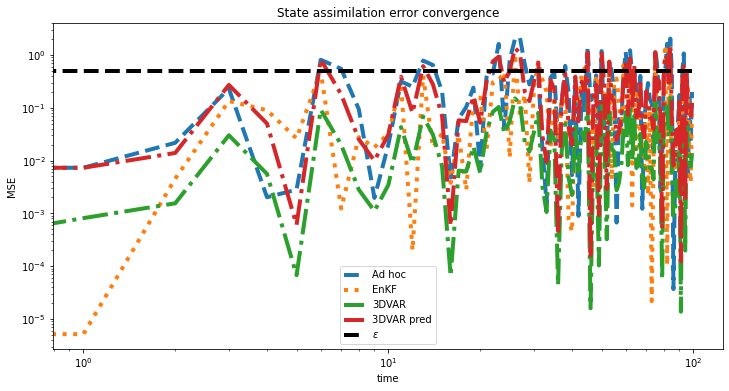

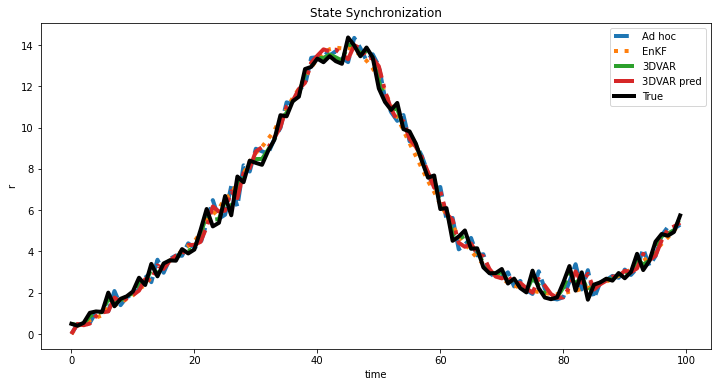

In [25]:
all_dict_da = get_initial_condition_DA(modelRINN, obs, 0.01, obs_noise_sd_true, model_cov=model_cov)


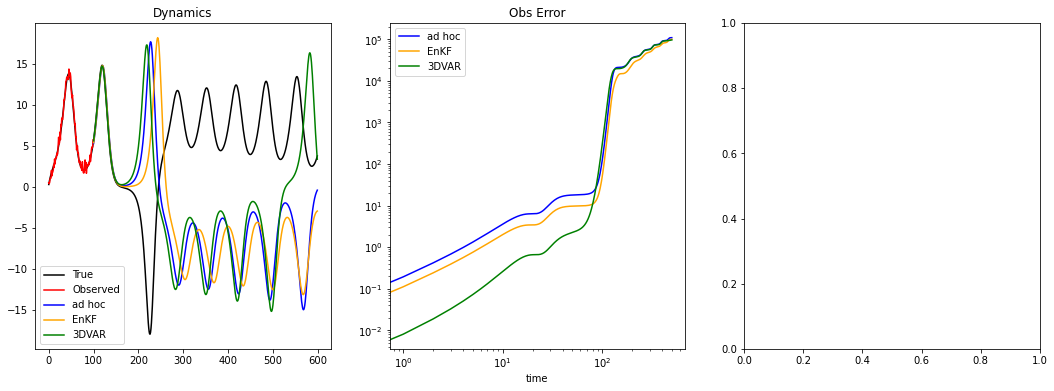

In [26]:
## Plot comparison of DA-based initial conditions in a test setting by iterating them forwards

# set color_key
colors = {'EnKF': 'orange', 'ad hoc': 'blue', 
          'True': 'black', '3DVAR': 'green', 
          'knn': 'purple',
          'torch.opt': 'magenta'}
# set dict
init_dict_da = {key: all_dict_da[key][-1,None] for key in all_dict_da}

fig0, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(X_test[initial_cond_idx:,0], label='True', color='black')
ax1.plot(obs, label='Observed', color='red') #400:500
ntest = X_test.shape[0] - initial_cond_idx - length_prior

for key in init_dict_da:
    y_pred=np.zeros((ntest,params['dim_Embedding']))
    mse=np.zeros(ntest)
    mse_cum=np.zeros(ntest)
    mse_all=np.zeros(ntest)
    mse_all_cum=np.zeros(ntest)

    tmp = torch.from_numpy(init_dict_da[key].astype(np.float32))
    y_pred[0,:] = tmp.cpu().data.numpy()
    for k in range(1,ntest):
        y_pred[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred[k,:],(1,params['dim_Embedding']))).float())
        mse[k] = np.mean((y_pred[k,0] - X_test[initial_cond_idx+length_prior+k,0])**2)
        mse_cum[k] = mse_cum[k-1] + mse[k]
        mse_all[k] = np.mean((y_pred[k] - X_test[initial_cond_idx+length_prior+k])**2)
        mse_all_cum[k] = mse_all_cum[k-1] + mse_all[k]
    plot_dict[key] = {'mse_cum': mse_cum, 'mse_all_cum': mse_all_cum, 'x':length_prior + np.arange(ntest), 'y_pred':y_pred[:,0]}
    ax1.plot(length_prior + np.arange(ntest),y_pred[:,0], label=key, color=colors[key])
#     ax1.plot(np.arange(ntest), y_pred3[:,0], label=key)
    ax2.plot(mse_cum, label=key, color=colors[key])
#     ax3.plot(mse_all_cum, label=key, color=colors[key])



ax1.legend()
ax1.set_title('Dynamics')
ax2.set_title('Obs Error')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('time')
ax2.legend()

# ax3.set_title('Full State Error')
# ax3.set_yscale('log')
# ax3.set_xscale('log')
# ax3.set_xlabel('time')
# ax3.legend()




In [27]:
# define variational assimilation problem
def get_initial_condition(model, time_series, train_series, dt,lr_init, err_tol = 1E-4, n_train = 10000, train_init = None):
    criterion = torch.nn.MSELoss()#reduction = 'sum')
    if train_init is None:
        min_idx = None
        inp_init = torch.rand(1,(train_series.shape[-1]+model.Int_net.Dyn_net.y_aug.shape[-1])).float()*0.0
        inp_init[:,:time_series.shape[-1]] = time_series.clone()[:1,:]
    else:
        inp_init = train_init
#         print(time_series.shape)
#         inp_init = get_init(time_series,time_series.shape[0],0.01,params['dim_Embedding'])

    init_cond_model = get_init_model(model,inp_init)
    optimizer = torch.optim.Adam(init_cond_model.parameters(), lr = lr_init)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, factor = 0.1, patience=205, verbose=True, min_lr = 0.0001)
    stop_cond = False
    count = 0
    while(stop_cond==False):
        # Forward pass: Compute predicted y by passing x to the model
        pred = init_cond_model(0.0,time_series.shape[0],dt)
        #pred1, grad, inp, aug_inp = modelRINN(test_vars[:1,:],dt, True, iterate = t)
        # Compute and print loss
        loss = torch.mean((pred[1:,0,:time_series.shape[-1]][torch.where(~torch.isnan(time_series))]- time_series[torch.where(~torch.isnan(time_series))])**2)
#        criterion(pred[1:,0,:time_series.shape[-1]], time_series[:,:])
        print(count,loss)
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
        scheduler.step(loss)
        count += 1
        if loss.detach().numpy()<err_tol or count>n_train:
            stop_cond = True
    return init_cond_model.estimate_init

class get_init_model(torch.nn.Module):
        def __init__(self, model_Multi_RINN, inp_init):
            super(get_init_model, self).__init__()
            self.Multi_INT_net = model_Multi_RINN
            self.estimate_init = torch.nn.Parameter((inp_init.clone()))#torch.nn.Parameter(aug_inp[:1,:])
        def forward(self, t0, nb, dt):
            pred = self.Multi_INT_net(self.estimate_init, t0, nb, dt)[0]
            return pred

In [28]:
print('Here are the original Dyn_net parameters')
for p in modelRINN.Dyn_net.parameters():
    print(p.name, p.data.shape, p.data)

Here are the original Dyn_net parameters
None torch.Size([1, 4000, 2]) tensor([[[ 0.0489, -0.2086],
         [ 0.0557, -0.1987],
         [ 0.0629, -0.1861],
         ...,
         [-0.0657, -0.0730],
         [-0.0708, -0.0647],
         [-0.0747, -0.0550]]])
None torch.Size([3, 3]) tensor([[ 0.2232,  5.4448, -4.6250],
        [ 0.1529, -3.2174, -0.2803],
        [ 0.5115,  2.6644, -0.3730]])
None torch.Size([3]) tensor([-0.7698, -0.4682,  0.1369])
None torch.Size([1, 3]) tensor([[0.2123, 1.0030, 1.0493]])
None torch.Size([1, 3]) tensor([[-0.0109, -4.7416, -4.3193]])
None torch.Size([1, 3]) tensor([[ 0.2480, -1.4997,  0.1511]])
None torch.Size([1, 3]) tensor([[-0.2012, -1.0158, -0.1593]])
None torch.Size([1, 3]) tensor([[ 0.8380, -7.5012,  3.7597]])
None torch.Size([1, 3]) tensor([[-0.2808,  0.0654,  1.7538]])
None torch.Size([3, 6]) tensor([[ 6.6845, -2.9261,  2.2588,  0.5806,  2.7221, -0.5150],
        [-0.4357,  1.3012, -0.1226, -0.4758,  0.1809,  0.0720],
        [ 1.0096,  0.0742

In [29]:
# define a copy of the model for which we only optimize ICs.
model_Multi_RINN = Multi_INT_net(params)
for param in model_Multi_RINN.Int_net.parameters():
   param.requires_grad = False 

In [33]:
# run variational assimilation with pytorch optimization
train_series = torch.from_numpy(X_train).float()
inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(obs).float(), train_series, 0.01,lr_init = 0.001, err_tol = 1E-1, n_train = 1000, train_init = inp_init_knn)
init_dict_opt['torch.opt'] = inp_init_opti
# inp_init_knn, inp_init_opti = get_initial_condition(model_Multi_RINN, torch.from_numpy(observations[initial_cond_idx:initial_cond_idx+length_prior,:1]).float(), train_series, 0.01,lr_init = 0.001, err_tol = 1E-1, n_train = 10000,

0 tensor(0.2479, grad_fn=<MeanBackward0>)
1 tensor(0.2430, grad_fn=<MeanBackward0>)
2 tensor(0.2388, grad_fn=<MeanBackward0>)
3 tensor(0.2351, grad_fn=<MeanBackward0>)
4 tensor(0.2319, grad_fn=<MeanBackward0>)
5 tensor(0.2291, grad_fn=<MeanBackward0>)
6 tensor(0.2266, grad_fn=<MeanBackward0>)
7 tensor(0.2242, grad_fn=<MeanBackward0>)
8 tensor(0.2218, grad_fn=<MeanBackward0>)
9 tensor(0.2193, grad_fn=<MeanBackward0>)
10 tensor(0.2169, grad_fn=<MeanBackward0>)
11 tensor(0.2146, grad_fn=<MeanBackward0>)
12 tensor(0.2124, grad_fn=<MeanBackward0>)
13 tensor(0.2103, grad_fn=<MeanBackward0>)
14 tensor(0.2085, grad_fn=<MeanBackward0>)
15 tensor(0.2068, grad_fn=<MeanBackward0>)
16 tensor(0.2052, grad_fn=<MeanBackward0>)
17 tensor(0.2038, grad_fn=<MeanBackward0>)
18 tensor(0.2024, grad_fn=<MeanBackward0>)
19 tensor(0.2010, grad_fn=<MeanBackward0>)
20 tensor(0.1998, grad_fn=<MeanBackward0>)
21 tensor(0.1986, grad_fn=<MeanBackward0>)
22 tensor(0.1974, grad_fn=<MeanBackward0>)
23 tensor(0.1964, gra

189 tensor(0.1876, grad_fn=<MeanBackward0>)
190 tensor(0.1876, grad_fn=<MeanBackward0>)
191 tensor(0.1876, grad_fn=<MeanBackward0>)
192 tensor(0.1875, grad_fn=<MeanBackward0>)
193 tensor(0.1875, grad_fn=<MeanBackward0>)
194 tensor(0.1875, grad_fn=<MeanBackward0>)
195 tensor(0.1875, grad_fn=<MeanBackward0>)
196 tensor(0.1875, grad_fn=<MeanBackward0>)
197 tensor(0.1875, grad_fn=<MeanBackward0>)
198 tensor(0.1875, grad_fn=<MeanBackward0>)
199 tensor(0.1875, grad_fn=<MeanBackward0>)
200 tensor(0.1875, grad_fn=<MeanBackward0>)
201 tensor(0.1875, grad_fn=<MeanBackward0>)
202 tensor(0.1875, grad_fn=<MeanBackward0>)
203 tensor(0.1874, grad_fn=<MeanBackward0>)
204 tensor(0.1874, grad_fn=<MeanBackward0>)
205 tensor(0.1874, grad_fn=<MeanBackward0>)
206 tensor(0.1874, grad_fn=<MeanBackward0>)
207 tensor(0.1874, grad_fn=<MeanBackward0>)
208 tensor(0.1874, grad_fn=<MeanBackward0>)
209 tensor(0.1874, grad_fn=<MeanBackward0>)
210 tensor(0.1874, grad_fn=<MeanBackward0>)
211 tensor(0.1874, grad_fn=<Mean

376 tensor(0.1858, grad_fn=<MeanBackward0>)
377 tensor(0.1858, grad_fn=<MeanBackward0>)
378 tensor(0.1858, grad_fn=<MeanBackward0>)
379 tensor(0.1858, grad_fn=<MeanBackward0>)
380 tensor(0.1858, grad_fn=<MeanBackward0>)
381 tensor(0.1858, grad_fn=<MeanBackward0>)
382 tensor(0.1857, grad_fn=<MeanBackward0>)
383 tensor(0.1857, grad_fn=<MeanBackward0>)
384 tensor(0.1857, grad_fn=<MeanBackward0>)
385 tensor(0.1857, grad_fn=<MeanBackward0>)
386 tensor(0.1857, grad_fn=<MeanBackward0>)
387 tensor(0.1857, grad_fn=<MeanBackward0>)
388 tensor(0.1857, grad_fn=<MeanBackward0>)
389 tensor(0.1857, grad_fn=<MeanBackward0>)
390 tensor(0.1857, grad_fn=<MeanBackward0>)
391 tensor(0.1857, grad_fn=<MeanBackward0>)
392 tensor(0.1856, grad_fn=<MeanBackward0>)
393 tensor(0.1856, grad_fn=<MeanBackward0>)
394 tensor(0.1856, grad_fn=<MeanBackward0>)
395 tensor(0.1856, grad_fn=<MeanBackward0>)
396 tensor(0.1856, grad_fn=<MeanBackward0>)
397 tensor(0.1856, grad_fn=<MeanBackward0>)
398 tensor(0.1856, grad_fn=<Mean

563 tensor(0.1842, grad_fn=<MeanBackward0>)
564 tensor(0.1842, grad_fn=<MeanBackward0>)
565 tensor(0.1842, grad_fn=<MeanBackward0>)
566 tensor(0.1842, grad_fn=<MeanBackward0>)
567 tensor(0.1842, grad_fn=<MeanBackward0>)
568 tensor(0.1842, grad_fn=<MeanBackward0>)
569 tensor(0.1842, grad_fn=<MeanBackward0>)
570 tensor(0.1842, grad_fn=<MeanBackward0>)
571 tensor(0.1841, grad_fn=<MeanBackward0>)
572 tensor(0.1841, grad_fn=<MeanBackward0>)
573 tensor(0.1841, grad_fn=<MeanBackward0>)
574 tensor(0.1841, grad_fn=<MeanBackward0>)
575 tensor(0.1841, grad_fn=<MeanBackward0>)
576 tensor(0.1841, grad_fn=<MeanBackward0>)
577 tensor(0.1841, grad_fn=<MeanBackward0>)
578 tensor(0.1841, grad_fn=<MeanBackward0>)
579 tensor(0.1841, grad_fn=<MeanBackward0>)
580 tensor(0.1841, grad_fn=<MeanBackward0>)
581 tensor(0.1841, grad_fn=<MeanBackward0>)
582 tensor(0.1841, grad_fn=<MeanBackward0>)
583 tensor(0.1841, grad_fn=<MeanBackward0>)
584 tensor(0.1841, grad_fn=<MeanBackward0>)
585 tensor(0.1840, grad_fn=<Mean

750 tensor(0.1830, grad_fn=<MeanBackward0>)
751 tensor(0.1830, grad_fn=<MeanBackward0>)
752 tensor(0.1830, grad_fn=<MeanBackward0>)
753 tensor(0.1830, grad_fn=<MeanBackward0>)
754 tensor(0.1830, grad_fn=<MeanBackward0>)
755 tensor(0.1830, grad_fn=<MeanBackward0>)
756 tensor(0.1830, grad_fn=<MeanBackward0>)
757 tensor(0.1830, grad_fn=<MeanBackward0>)
758 tensor(0.1830, grad_fn=<MeanBackward0>)
759 tensor(0.1830, grad_fn=<MeanBackward0>)
760 tensor(0.1829, grad_fn=<MeanBackward0>)
761 tensor(0.1829, grad_fn=<MeanBackward0>)
762 tensor(0.1829, grad_fn=<MeanBackward0>)
763 tensor(0.1829, grad_fn=<MeanBackward0>)
764 tensor(0.1829, grad_fn=<MeanBackward0>)
765 tensor(0.1829, grad_fn=<MeanBackward0>)
766 tensor(0.1829, grad_fn=<MeanBackward0>)
767 tensor(0.1829, grad_fn=<MeanBackward0>)
768 tensor(0.1829, grad_fn=<MeanBackward0>)
769 tensor(0.1829, grad_fn=<MeanBackward0>)
770 tensor(0.1829, grad_fn=<MeanBackward0>)
771 tensor(0.1829, grad_fn=<MeanBackward0>)
772 tensor(0.1829, grad_fn=<Mean

937 tensor(0.1822, grad_fn=<MeanBackward0>)
938 tensor(0.1822, grad_fn=<MeanBackward0>)
939 tensor(0.1822, grad_fn=<MeanBackward0>)
940 tensor(0.1822, grad_fn=<MeanBackward0>)
941 tensor(0.1822, grad_fn=<MeanBackward0>)
942 tensor(0.1822, grad_fn=<MeanBackward0>)
943 tensor(0.1822, grad_fn=<MeanBackward0>)
944 tensor(0.1822, grad_fn=<MeanBackward0>)
945 tensor(0.1822, grad_fn=<MeanBackward0>)
946 tensor(0.1822, grad_fn=<MeanBackward0>)
947 tensor(0.1822, grad_fn=<MeanBackward0>)
948 tensor(0.1822, grad_fn=<MeanBackward0>)
949 tensor(0.1822, grad_fn=<MeanBackward0>)
950 tensor(0.1822, grad_fn=<MeanBackward0>)
951 tensor(0.1821, grad_fn=<MeanBackward0>)
952 tensor(0.1821, grad_fn=<MeanBackward0>)
953 tensor(0.1821, grad_fn=<MeanBackward0>)
954 tensor(0.1821, grad_fn=<MeanBackward0>)
955 tensor(0.1821, grad_fn=<MeanBackward0>)
956 tensor(0.1821, grad_fn=<MeanBackward0>)
957 tensor(0.1821, grad_fn=<MeanBackward0>)
958 tensor(0.1821, grad_fn=<MeanBackward0>)
959 tensor(0.1821, grad_fn=<Mean

In [34]:
print('Here are the modified Dyn_net parameters')
for p in modelRINN.Dyn_net.parameters():
    print(p.name, p.data.shape, p.data)

Here are the modified Dyn_net parameters
None torch.Size([1, 4000, 2]) tensor([[[ 0.0489, -0.2086],
         [ 0.0557, -0.1987],
         [ 0.0629, -0.1861],
         ...,
         [-0.0657, -0.0730],
         [-0.0708, -0.0647],
         [-0.0747, -0.0550]]])
None torch.Size([3, 3]) tensor([[ 0.2232,  5.4448, -4.6250],
        [ 0.1529, -3.2174, -0.2803],
        [ 0.5115,  2.6644, -0.3730]])
None torch.Size([3]) tensor([-0.7698, -0.4682,  0.1369])
None torch.Size([1, 3]) tensor([[0.2123, 1.0030, 1.0493]])
None torch.Size([1, 3]) tensor([[-0.0109, -4.7416, -4.3193]])
None torch.Size([1, 3]) tensor([[ 0.2480, -1.4997,  0.1511]])
None torch.Size([1, 3]) tensor([[-0.2012, -1.0158, -0.1593]])
None torch.Size([1, 3]) tensor([[ 0.8380, -7.5012,  3.7597]])
None torch.Size([1, 3]) tensor([[-0.2808,  0.0654,  1.7538]])
None torch.Size([3, 6]) tensor([[ 6.6845, -2.9261,  2.2588,  0.5806,  2.7221, -0.5150],
        [-0.4357,  1.3012, -0.1226, -0.4758,  0.1809,  0.0720],
        [ 1.0096,  0.0742

In [35]:
# add optimization and KNN methods to plot for comparison 
for key in init_dict_opt:
    mse_cum=np.zeros(ntest)
    mse_all_cum=np.zeros(ntest)

    y_pred=np.zeros((length_prior + ntest,params['dim_Embedding']))
    tmp = init_dict_opt[key]
    y_pred[0,:] = tmp.cpu().data.numpy()
    for k in range(1,length_prior + ntest):
        y_pred[k,:] = modelRINN(tmp,0.01)[0].cpu().data.numpy()
        tmp = (torch.from_numpy(np.reshape(y_pred[k,:],(1,params['dim_Embedding']))).float())
        mse_k = np.mean((y_pred[k,0] - X_test[initial_cond_idx+k,0])**2)
        mse_all_k = np.mean((y_pred[k] - X_test[initial_cond_idx+k])**2)
        if k>=length_prior:
            mse_cum[k-length_prior] = mse_cum[k-1-length_prior] + mse_k
            mse_all_cum[k-length_prior] = mse_all_cum[k-1-length_prior] + mse_all_k

    plot_dict[key] = {'mse_cum': mse_cum, 'mse_all_cum': mse_all_cum, 'x': length_prior + np.arange(ntest), 'y_pred': y_pred[length_prior:,0]}
#     ax1.plot(length_prior + np.arange(ntest), y_pred[length_prior:,0], label=key, color=colors[key])
#     ax2.plot(mse_cum, label=key, color=colors[key])
#     ax3.plot(mse_all_cum, label=key, color=colors[key])

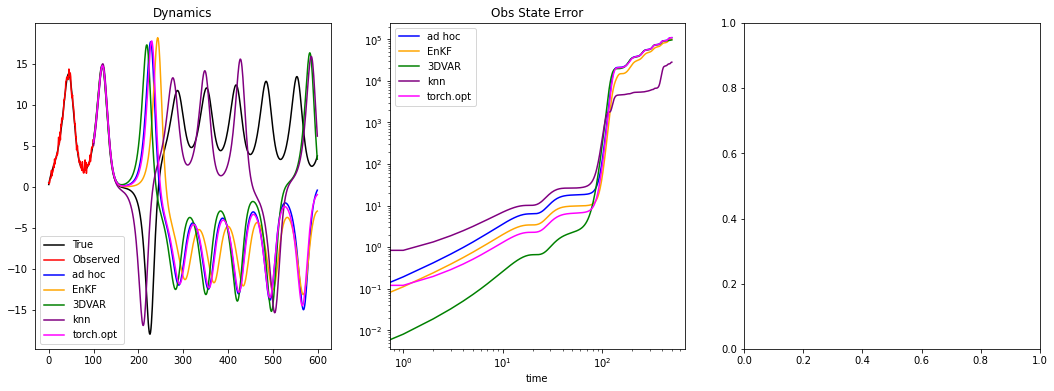

In [36]:
fig0, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18,6))
ax1.plot(X_test[initial_cond_idx:,0], label='True', color='black')
ax1.plot(obs, label='Observed', color='red') #400:500
for key in init_dict_da.keys():
    foo = plot_dict[key]
    ax1.plot(foo['x'], foo['y_pred'], label=key, color=colors[key])
    ax2.plot(foo['mse_cum'], label=key, color=colors[key])

for key in init_dict_opt.keys():
    foo = plot_dict[key]
    ax1.plot(foo['x'], foo['y_pred'], label=key, color=colors[key])
    ax2.plot(foo['mse_cum'], label=key, color=colors[key])
#     ax3.plot(foo['mse_all_cum'], label=key, color=colors[key])



ax1.legend()
ax1.set_title('Dynamics')
ax2.set_title('Obs State Error')
ax2.set_yscale('log')
ax2.set_xscale('log')
ax2.set_xlabel('time')
ax2.legend()

# ax3.set_title('Full State Error')
# ax3.set_yscale('log')
# ax3.set_xscale('log')
# ax3.set_xlabel('time')
# ax3.legend()


In [ ]:
print('DA initial conditions (at t=initial_cond_idx+length_prior)...')
for key in init_dict_da:
    print(key, ':', init_dict_da[key])

print('\nOptimization-based initial conditions (at t=initial_cond_idx)...')
for key in init_dict_opt:
    print(key,':',init_dict_opt[key])

